# Problem 1: StyleGAN


In [ ]:
# setup correct PyTorch version
!pip install -U torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
import torch 

# Download the code
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

# install other dependencies 
!pip install ninja

print('PyTorch version: {}'.format(torch.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(torch.cuda.get_device_name()))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2)
ERROR: No matching distribution found for torch==1.7.1+cu110
Cloning into 'stylegan2-ada-pytor

In [ ]:
# Download the model
import argparse
import numpy as np
import PIL.Image
import dnnlib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio
import matplotlib.pyplot as plt
import legacy
import cv2
import torch
from tqdm.autonotebook import tqdm

device = torch.device('cuda')

# Choose between these pretrained models
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqdog.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqwild.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/brecahad.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

# If downloads fails, you can try downloading manually and uploading to the session directly 
# network_pkl = "/content/ffhq.pkl"

print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as f:
  G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...

<ipython-input-2-97737518342e>:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


 done


In [ ]:
# Useful utility functions...

# Generates an image from a style vector.
def generate_image_from_style(dlatent, noise_mode='none'):

  if len(dlatent.shape) == 1: 
    dlatent = dlatent.unsqueeze(0)
    
  row_images = G.synthesis(dlatent, noise_mode=noise_mode)
  row_images = (row_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return row_images[0].cpu().numpy()    

# Converts a noise vector z to a style vector w.
def convert_z_to_w(latent, truncation_psi=0.7, truncation_cutoff=9, class_idx=None):
  label = torch.zeros([1, G.c_dim], device=device)   
  if G.c_dim != 0:
    if class_idx is None:
      RuntimeError('Must specify class label with class_idx when using a conditional network')
    label[:, class_idx] = 1
  else:
    if class_idx is not None:
      print(f'warning: class_idx={class_idx} ignored when running on an unconditional network')
  return G.mapping(latent, label, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


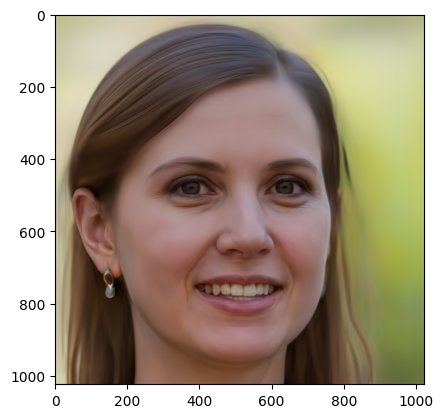

In [ ]:
# Sample code to generate images.
np.random.seed(120) # You can change this random seed.

# Generate a random noise (z) vector. 
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)

# Convert z vector to w vector.
w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img = generate_image_from_style(w)
plt.imshow(img)

## LATENT SPACE FACE TRAVERSALS

In [ ]:
# download 
!gdown "1NcRdVWicD1pS1X_XN3MfBrXQwffhB3wF" -O "../"

Downloading...
From: https://drive.google.com/uc?id=1NcRdVWicD1pS1X_XN3MfBrXQwffhB3wF
To: /content/ffhq-gender,age,pitch,roll,yaw.weights
100% 94.4M/94.4M [00:00<00:00, 265MB/s]


In [ ]:
from torchvision import models as tv
cnn = tv.resnet50(pretrained=False, progress=True, num_classes = 5)
cnn.eval()
cnn.load_state_dict(torch.load('../ffhq-gender,age,pitch,roll,yaw.weights', map_location=lambda storage, loc: storage))

# Returns whether face is perceptually female (True) or male (False) given
# an input image of shape (H, W, 3).
def face_is_female(img):
  im = np.asarray(img)/255.0
  im = cv2.resize(im, (256, 256))
  im = np.expand_dims(np.transpose(im, (2,0,1)), 0)
  im = torch.FloatTensor(im)
  logits = cnn(im)[0, 0]
  return (logits < 0.5).numpy()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Problem 1a: Interpolation between two faces and gender classification.

True


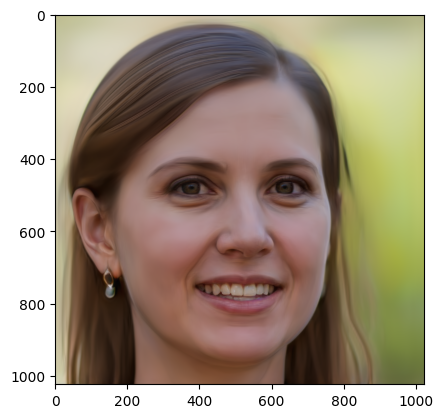

In [ ]:
# Your code goes here.

# Sample code to generate images.
np.random.seed(120) # You can change this random seed.

# Generate a random noise (z) vector. 
z0 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)

# Convert z vector to w vector.
w0 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img0 = generate_image_from_style(w0)
plt.imshow(img0)

print(face_is_female(img0))
im= Image.fromarray(img0)
im.save('img0.jpg')

False


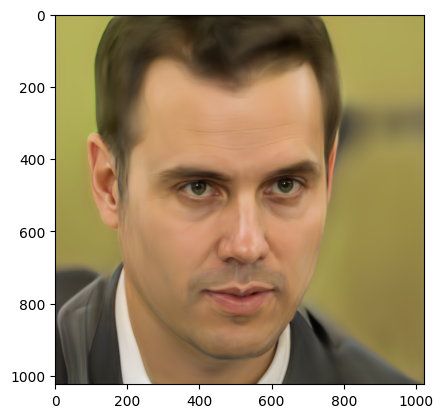

In [ ]:
# Sample code to generate images.
np.random.seed(12) # You can change this random seed.

# Generate a random noise (z) vector. 
z1 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)

# Convert z vector to w vector.
w1 = convert_z_to_w(z1, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img1 = generate_image_from_style(w1)
plt.imshow(img1)

print(face_is_female(img1))

In [ ]:

num_intermediate_points = 5

# set the interpolation parameter values (evenly spaced between 0 and 1)
alphas = np.linspace(0, 1, num_intermediate_points + 2)[1:-1]

# compute the intermediate vectors using linear interpolation
intermediate_vectors = []
for alpha in alphas:
    interpolated_vector = alpha * z0 + (1 - alpha) * z1
    intermediate_vectors.append(interpolated_vector)

# combine the original vectors and the intermediate vectors into a single list
vectors = [z0] + intermediate_vectors + [z1]


False


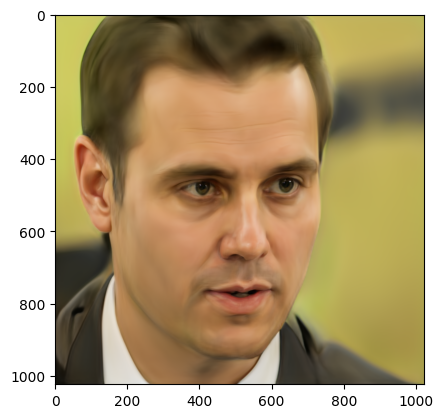

In [ ]:
z10 = intermediate_vectors[0]

# Convert z vector to w vector.
w10 = convert_z_to_w(z10, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img10 = generate_image_from_style(w10)
plt.imshow(img10)

print(face_is_female(img10))

False


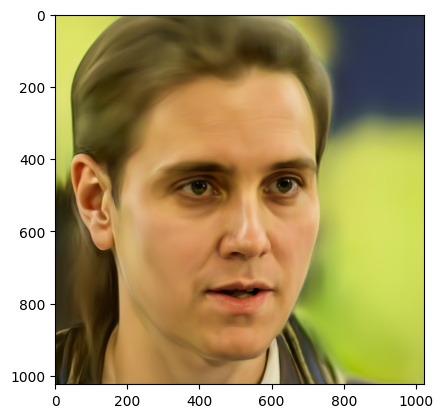

In [ ]:
z11 = intermediate_vectors[1]

# Convert z vector to w vector.
w11 = convert_z_to_w(z11, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img11 = generate_image_from_style(w11)
plt.imshow(img11)

print(face_is_female(img11))

False


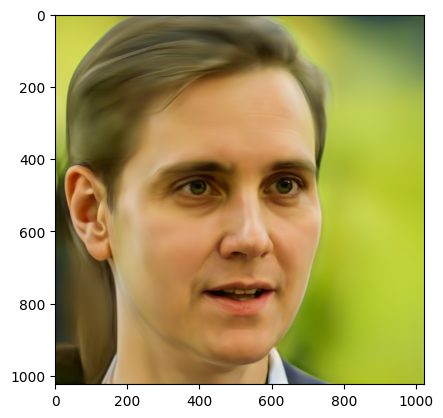

In [ ]:
z12 = intermediate_vectors[2]

# Convert z vector to w vector.
w12 = convert_z_to_w(z12, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img12 = generate_image_from_style(w12)
plt.imshow(img12)

print(face_is_female(img12))

False


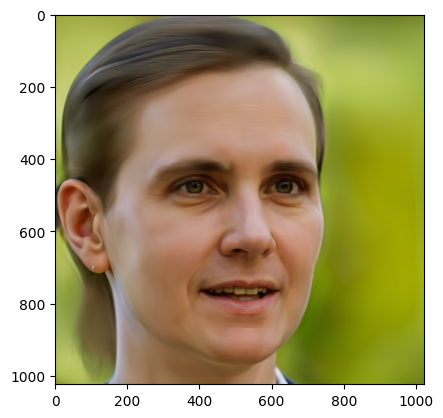

In [ ]:
z13 = intermediate_vectors[3]

# Convert z vector to w vector.
w13 = convert_z_to_w(z13, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img13 = generate_image_from_style(w13)
plt.imshow(img13)

print(face_is_female(img13))

True


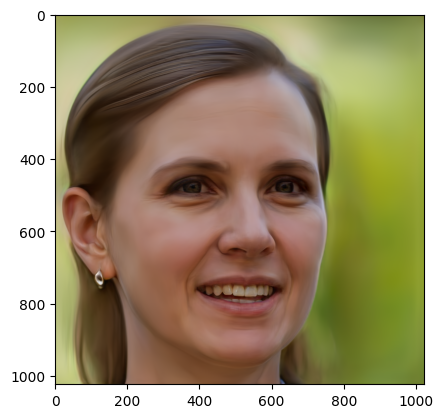

In [ ]:
z14 = intermediate_vectors[4]

# Convert z vector to w vector.
w14 = convert_z_to_w(z14, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img14 = generate_image_from_style(w14)
plt.imshow(img14)

print(face_is_female(img14))

In [ ]:
intermediate_ws = []
for alpha in alphas:
    interpolated_w = alpha * w0 + (1 - alpha) * w1
    intermediate_ws.append(interpolated_w)

print(len(intermediate_ws))

5


False


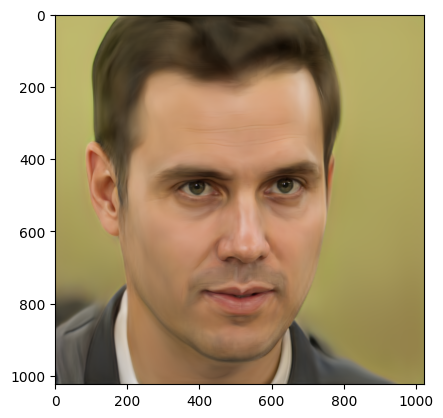

In [ ]:
w20 = intermediate_ws[0]

# Generate and show image.
img20 = generate_image_from_style(w20)
plt.imshow(img20)

print(face_is_female(img20))

False


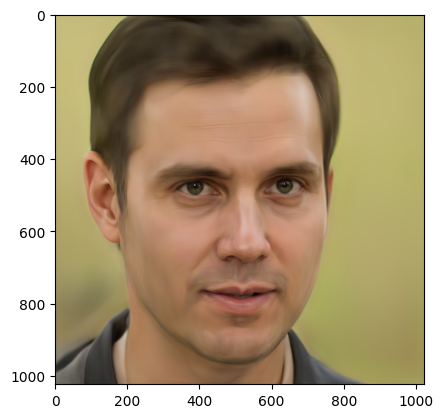

In [ ]:
w21 = intermediate_ws[1]

# Generate and show image.
img21 = generate_image_from_style(w21)
plt.imshow(img21)

print(face_is_female(img21))

False


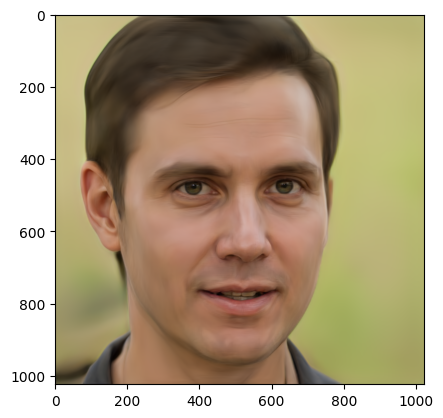

In [ ]:
w22 = intermediate_ws[2]

# Generate and show image.
img22 = generate_image_from_style(w22)
plt.imshow(img22)

print(face_is_female(img22))

True


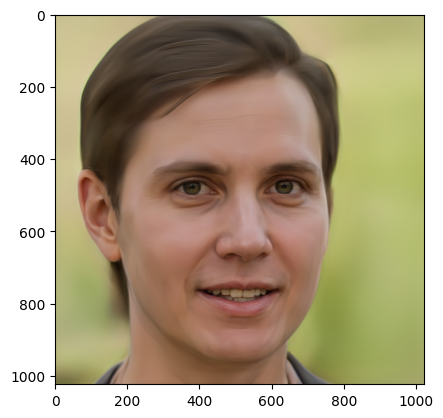

In [ ]:
w23 = intermediate_ws[3]

# Generate and show image.
img23 = generate_image_from_style(w23)
plt.imshow(img23)

print(face_is_female(img23))

True


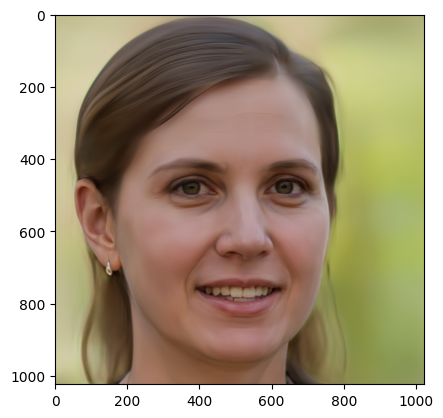

In [ ]:
w24 = intermediate_ws[4]

# Generate and show image.
img24 = generate_image_from_style(w24)
plt.imshow(img24)

print(face_is_female(img24))

Problem 1b: Latent space traversals

True


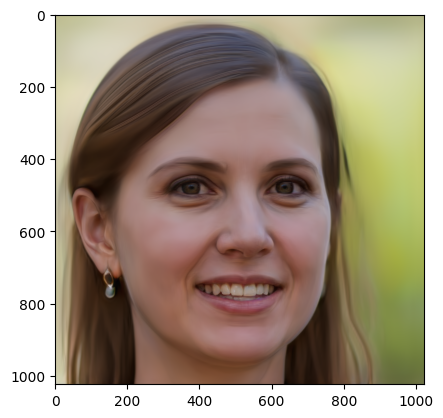

In [ ]:
# Your code goes here.
# Sample code to generate images.
np.random.seed(120) # You can change this random seed.

# Generate a random noise (z) vector. 
z0 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)

# Convert z vector to w vector.
w0 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img0 = generate_image_from_style(w0)
plt.imshow(img0)

print(face_is_female(img0))
im= Image.fromarray(img0)
im.save('img0.jpg')

Sample 1000 random z vectors

In [ ]:
train_num = 1000

X_train_list = []
y_train_list = []

for i in range(train_num):
  z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
  w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9)
  X_train_list.append(w)
  img = generate_image_from_style(w)
  y_train_list.append(face_is_female(img))


In [ ]:
from sklearn.svm import LinearSVC

X_train = np.array([t.cpu().numpy() for t in X_train_list])
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = np.array(y_train_list)

# Instantiate the LinearSVC model
svm_model = LinearSVC()

# Train the model on the training data
svm_model.fit(X_train, y_train)

LinearSVC()

In [ ]:
coef = svm_model.coef_
coef = coef.reshape(1, 18, 512)
normal_vector = coef / np.linalg.norm(coef)
normal_vector = torch.from_numpy(normal_vector).to(device)

Sample 1st random w vector

True


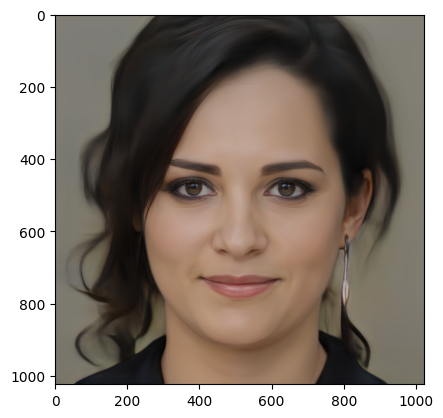

In [ ]:
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9)

img = generate_image_from_style(w)
plt.imshow(img)

print(face_is_female(img))

False


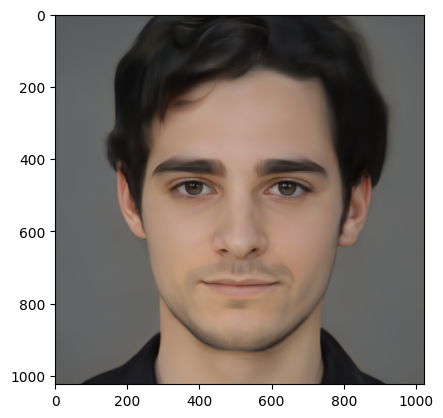

In [ ]:
w31 = w + normal_vector * (-15)

img31 = generate_image_from_style(w31)
plt.imshow(img31)

print(face_is_female(img31))

False


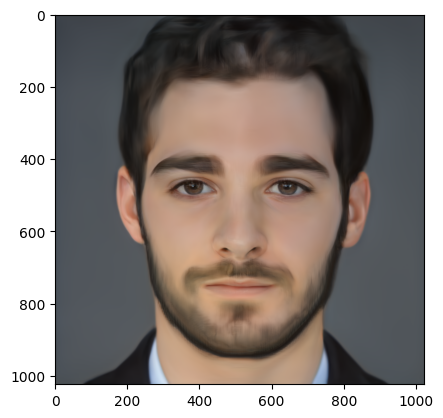

In [ ]:
w32 = w + normal_vector * (-30)

img32 = generate_image_from_style(w32)
plt.imshow(img32)

print(face_is_female(img32))

True


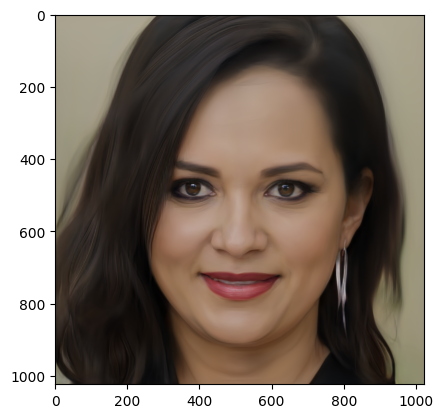

In [ ]:
w33 = w + normal_vector * (15)

img33 = generate_image_from_style(w33)
plt.imshow(img33)

print(face_is_female(img33))

True


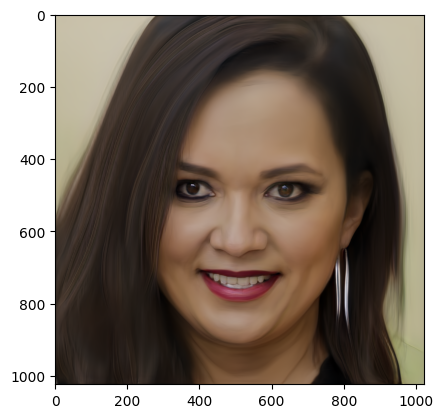

In [ ]:
w34 = w + normal_vector * (30)

img34 = generate_image_from_style(w34)
plt.imshow(img34)

print(face_is_female(img34))

Sample 2nd random w vector

False


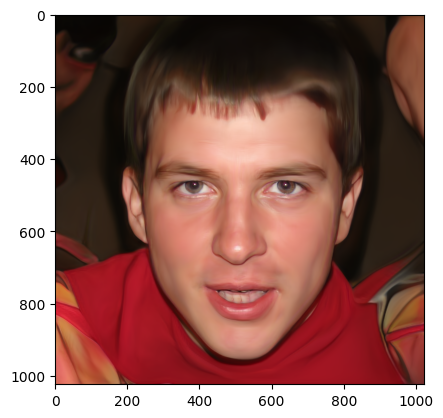

In [ ]:
z40 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
w40 = convert_z_to_w(z40, truncation_psi=0.7, truncation_cutoff=9)

img40 = generate_image_from_style(w40)
plt.imshow(img40)

print(face_is_female(img40))

False


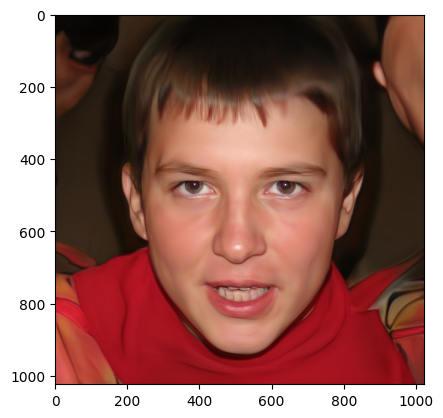

In [ ]:
w41 = w40 + normal_vector * (10)

img41 = generate_image_from_style(w41)
plt.imshow(img41)

print(face_is_female(img41))

True


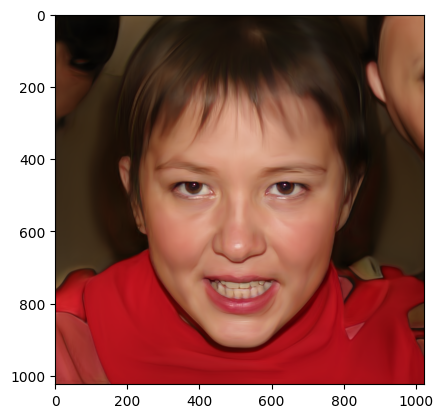

In [ ]:
w42 = w40 + normal_vector * (30)

img42 = generate_image_from_style(w42)
plt.imshow(img42)

print(face_is_female(img42))

False


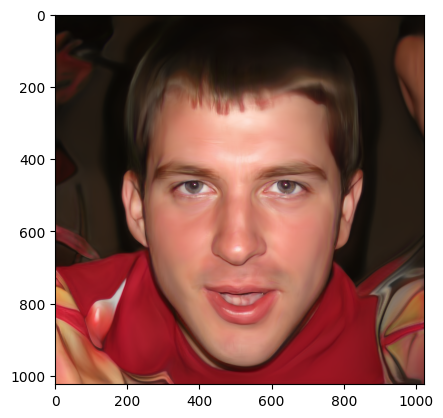

In [ ]:
w43 = w40 + normal_vector * (-10)

img43 = generate_image_from_style(w43)
plt.imshow(img43)

print(face_is_female(img43))

False


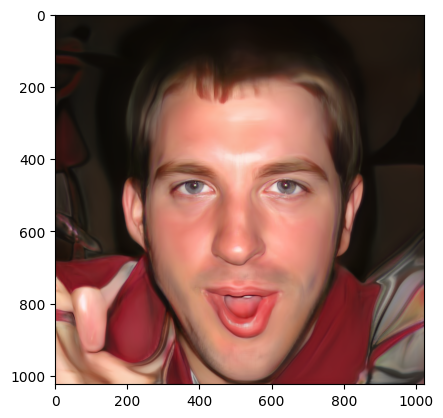

In [ ]:
w44 = w40 + normal_vector * (-30)

img44 = generate_image_from_style(w44)
plt.imshow(img44)

print(face_is_female(img44))

# Problem 2: CLIP

In [ ]:
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-25pq1_sz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-25pq1_sz
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=58bb0bc400d0d6a6a55c39d291272a0b68d8d97dda7071af9929472d87b01a30
  Stored in directory: /tmp/pip-ephem-wheel-cache-r1yem6kh/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import clip

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 243MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

cifar = np.load('/content/drive/MyDrive/CIFAR.npz') # Replace with your path to CIFAR.
X,y,label_names = cifar['X'], cifar['y']*1.0, cifar['label_names']
print(label_names)

Mounted at /content/drive
['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [ ]:
from tqdm import tqdm
captions = [f"An image of {label}" for label in label_names]
#captions = ['An image of a airplane', 'An image of a automobile', 'An image of a bird', 'An image of a cat', 'An image of a deer', 'An image of a dog', 'An image of a frog', 'An image of a horse', 'An image of a ship', 'An image of a truck'] # Your code goes here.
predicted_captions = []
correct = 0

# Iterate over all test examples.
for i in tqdm(range(50000, 60000)): 
  image = preprocess(Image.fromarray(np.uint8(X[i,...]))).unsqueeze(0).to('cuda')
  text = clip.tokenize(captions).to(device)

  with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text) 
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # Your code goes here.
    if np.argmax(probs) == y[i]:
      correct += 1

    predicted_captions.append(captions[np.argmax(probs)])

# Your code goes here.
correct /= 10000

print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%")


100%|██████████| 10000/10000 [17:28<00:00,  9.53it/s]

Test Error: 
 Accuracy: 89.7%


In [ ]:
print(predicted_captions)

['An image of cat', 'An image of ship', 'An image of ship', 'An image of airplane', 'An image of frog', 'An image of dog', 'An image of automobile', 'An image of frog', 'An image of cat', 'An image of automobile', 'An image of airplane', 'An image of truck', 'An image of dog', 'An image of horse', 'An image of truck', 'An image of ship', 'An image of dog', 'An image of horse', 'An image of ship', 'An image of frog', 'An image of horse', 'An image of airplane', 'An image of deer', 'An image of truck', 'An image of dog', 'An image of bird', 'An image of deer', 'An image of airplane', 'An image of truck', 'An image of frog', 'An image of frog', 'An image of dog', 'An image of deer', 'An image of dog', 'An image of truck', 'An image of bird', 'An image of deer', 'An image of automobile', 'An image of truck', 'An image of dog', 'An image of deer', 'An image of frog', 'An image of bird', 'An image of frog', 'An image of airplane', 'An image of truck', 'An image of cat', 'An image of ship', '

2b

In [ ]:
multi_captions = []

for label in label_names:
    bad_photo_caption = f"A bad photo of a {label}"
    drawing_caption = f"A drawing of a {label}"
    low_resolution_caption = f"A low-resolution of a {label}"
    
    multi_captions.append([bad_photo_caption, drawing_caption, low_resolution_caption])

print(multi_captions)

[['A bad photo of a airplane', 'A drawing of a airplane', 'A low-resolution of a airplane'], ['A bad photo of a automobile', 'A drawing of a automobile', 'A low-resolution of a automobile'], ['A bad photo of a bird', 'A drawing of a bird', 'A low-resolution of a bird'], ['A bad photo of a cat', 'A drawing of a cat', 'A low-resolution of a cat'], ['A bad photo of a deer', 'A drawing of a deer', 'A low-resolution of a deer'], ['A bad photo of a dog', 'A drawing of a dog', 'A low-resolution of a dog'], ['A bad photo of a frog', 'A drawing of a frog', 'A low-resolution of a frog'], ['A bad photo of a horse', 'A drawing of a horse', 'A low-resolution of a horse'], ['A bad photo of a ship', 'A drawing of a ship', 'A low-resolution of a ship'], ['A bad photo of a truck', 'A drawing of a truck', 'A low-resolution of a truck']]


In [ ]:
#for i in tqdm(range(50000, 60000)): 
#  image = preprocess(Image.fromarray(np.uint8(X[i,...]))).unsqueeze(0).to('cuda')
flat_multi_captions = [caption for captions in multi_captions for caption in captions]
captions_tokenized = clip.tokenize(flat_multi_captions).to(device)

print(flat_multi_captions)

['A bad photo of a airplane', 'A drawing of a airplane', 'A low-resolution of a airplane', 'A bad photo of a automobile', 'A drawing of a automobile', 'A low-resolution of a automobile', 'A bad photo of a bird', 'A drawing of a bird', 'A low-resolution of a bird', 'A bad photo of a cat', 'A drawing of a cat', 'A low-resolution of a cat', 'A bad photo of a deer', 'A drawing of a deer', 'A low-resolution of a deer', 'A bad photo of a dog', 'A drawing of a dog', 'A low-resolution of a dog', 'A bad photo of a frog', 'A drawing of a frog', 'A low-resolution of a frog', 'A bad photo of a horse', 'A drawing of a horse', 'A low-resolution of a horse', 'A bad photo of a ship', 'A drawing of a ship', 'A low-resolution of a ship', 'A bad photo of a truck', 'A drawing of a truck', 'A low-resolution of a truck']


In [ ]:
results = []
num_captions_per_class = len(multi_captions[0])
correct_mult = 0
predicted_captions_mult = []

for i in tqdm(range(50000, 60000)): 
  image = preprocess(Image.fromarray(np.uint8(X[i,...]))).unsqueeze(0).to('cuda')

  with torch.no_grad():
    image_features = model.encode_image(image)
    captions_tokenized_features = model.encode_text(captions_tokenized)
    logits_per_image, logits_per_text = model(image, captions_tokenized)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    combined_result = []
    for k in range(0, len(multi_captions)):
      combined_result.append(np.mean(probs[k*num_captions_per_class:(k+1)*num_captions_per_class]))

    if np.argmax(combined_result) == y[i]:
      correct_mult += 1

    predicted_captions_mult.append(flat_multi_captions[np.argmax(probs)])

correct_mult /= 10000

print(f"Test Error: \n Accuracy: {(100*correct_mult):>0.1f}%")

100%|██████████| 10000/10000 [51:47<00:00,  3.22it/s]

Test Error: 
 Accuracy: 10.0%


In [ ]:
print(predicted_captions_mult)

['A low-resolution of a cat', 'A low-resolution of a ship', 'A low-resolution of a automobile', 'A low-resolution of a airplane', 'A low-resolution of a frog', 'A low-resolution of a cat', 'A low-resolution of a automobile', 'A low-resolution of a frog', 'A low-resolution of a cat', 'A low-resolution of a automobile', 'A low-resolution of a airplane', 'A low-resolution of a truck', 'A low-resolution of a dog', 'A low-resolution of a horse', 'A low-resolution of a truck', 'A low-resolution of a ship', 'A low-resolution of a dog', 'A low-resolution of a horse', 'A low-resolution of a ship', 'A low-resolution of a frog', 'A low-resolution of a horse', 'A low-resolution of a bird', 'A low-resolution of a deer', 'A low-resolution of a truck', 'A low-resolution of a dog', 'A low-resolution of a bird', 'A low-resolution of a deer', 'A low-resolution of a airplane', 'A low-resolution of a truck', 'A low-resolution of a frog', 'A low-resolution of a frog', 'A low-resolution of a dog', 'A low-re